In [1]:
from rsam import RSAM

# Please change variables inside variables.py
from variables import *
from utilities import fill_streams

# Plot RSAM

In [2]:
def main():
    # ============================================
    # Running RSAM per station
    for station in stations:

        csv_files[station]: list[str] = []

        # Calculate RSAM per station per date
        for date in dates:
            date_string = date.strftime('%Y-%m-%d')

            # Save stream on a list of streams
            streams[date_string]: Stream = fill_streams(client, station, date)

            # Make sure stream is not empty
            if streams[date_string].count():

                # Run the RSAM per day
                rsam = RSAM(streams[date_string], resample=resample_rule, bands=bands)

                # Add RSAM CSV file result to CSV list 
                csv_files[station].append(rsam.save(rsam_directory))

        # Combining RSAM CSV results per station name
        print(RSAM.concatenate_csv(rsam_directory, station, resample_rule))
    
    # Plot RSAM
    RSAM.plot(rsam_directory, stations, resample_rule, axvspans=continuous_eruptions, axvlines=single_eruptions)

⚠️ 2017-10-01 :: File(s) not found!
⚠️ 2017-10-02 :: File(s) not found!
⚠️ 2017-10-03 :: File(s) not found!
⚠️ 2017-10-04 :: File(s) not found!
⚠️ 2017-10-05 :: File(s) not found!
⚠️ 2017-10-06 :: File(s) not found!
⚠️ 2017-10-07 :: File(s) not found!
⚠️ 2017-10-08 :: File(s) not found!
⚠️ 2017-10-09 :: File(s) not found!
⚠️ 2017-10-10 :: File(s) not found!
⚠️ 2017-10-11 :: File(s) not found!
⚠️ 2017-10-12 :: File(s) not found!
⚠️ 2017-10-13 :: File(s) not found!
⚠️ 2017-10-14 :: File(s) not found!
⚠️ 2017-10-15 :: File(s) not found!
⚠️ 2017-10-16 :: File(s) not found!
⛔ 2017-10-17 :: File(s) INVALID!
⌚ Processing 2017-10-18 for VG.PSAG.00.EHZ
💾 Saving to D:\Projects\dsar\output\rsam\VG.PSAG.00.EHZ\10min\VG.PSAG.00.EHZ_2017-10-18.csv
⌚ Processing 2017-10-19 for VG.PSAG.00.EHZ
💾 Saving to D:\Projects\dsar\output\rsam\VG.PSAG.00.EHZ\10min\VG.PSAG.00.EHZ_2017-10-19.csv
⌚ Processing 2017-10-20 for VG.PSAG.00.EHZ
💾 Saving to D:\Projects\dsar\output\rsam\VG.PSAG.00.EHZ\10min\VG.PSAG.00.EHZ_2

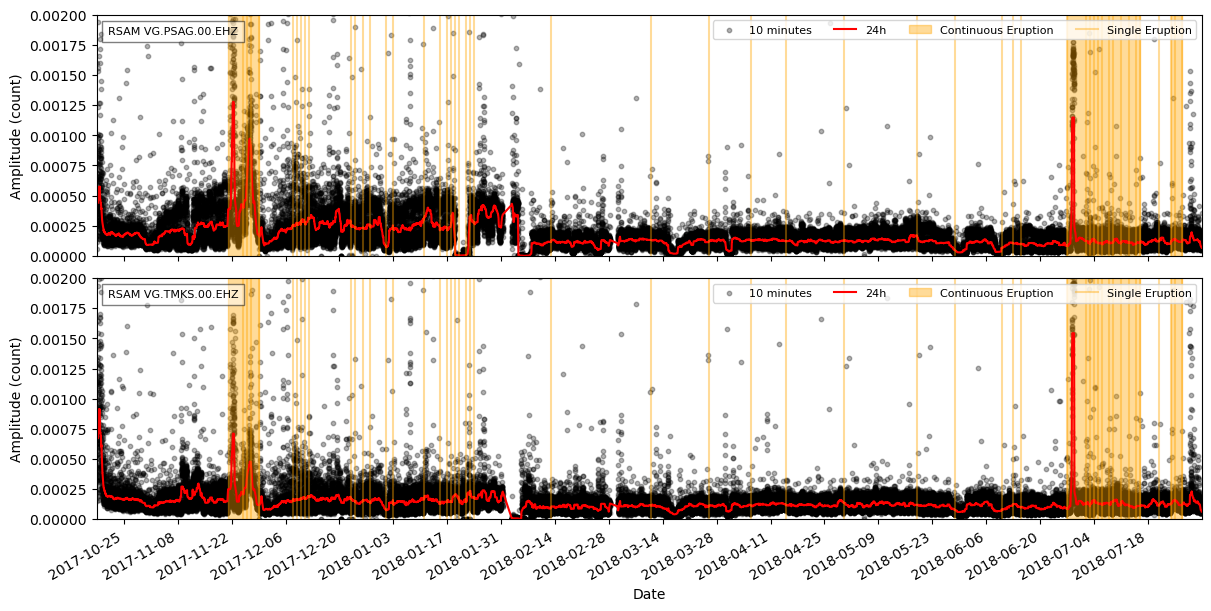

In [3]:
main()